# **Import Libraries**

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input



# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

# **Configure GPU**

In [ ]:
# Configure GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU")


Physical devices cannot be modified after being initialized


# **Load data**

In [ ]:
# Load data
def load_data(folder_path):
    classes = ['no', 'sphere', 'vort']
    X = []
    y = []

    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(folder_path, class_name)
        files = [f for f in os.listdir(class_path) if f.endswith('.npy')]

        for file in tqdm(files, desc=f'Loading {class_name} data'):
            file_path = os.path.join(class_path, file)
            data = np.load(file_path)

            # Ensure shape is (150, 150, 1)
            if data.shape == (1, 150, 150):
                data = np.transpose(data, (1, 2, 0))
            elif data.shape == (150, 150):
                data = np.expand_dims(data, axis=-1)

            X.append(data)
            y.append(class_idx)

    return np.array(X), np.array(y)

# Load data
print("Loading training data...")
X_train, y_train = load_data('/kaggle/input/gsoc-data/dataset/train')
print("\nLoading validation data...")
X_val, y_val = load_data('/kaggle/input/gsoc-data/dataset/val')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Convert labels
num_classes = 3
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)
y_val_onehot = to_categorical(y_val, num_classes)

Loading training data...


Loading vort data: 100%|██████████| 10000/10000 [00:21<00:00, 469.60it/s]



Loading validation data...


Loading vort data: 100%|██████████| 2500/2500 [00:06<00:00, 388.45it/s]


# **ResNet50 model**

In [ ]:
# Create model
def create_resnet_model():
    # Load base ResNet50 without top layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    # Create new model with single channel input
    inputs = Input(shape=(150, 150, 1))

    # Properly convert 1 channel to 3 channels by repeating
    x = Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Apply preprocessing for ResNet
    x = Lambda(lambda x: preprocess_input(x * 255))(x)

    # Pass through ResNet
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

# Create model
model, base_model = create_resnet_model()
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 150, 150, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_7 (Lambda)                    │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# **Defininng Early Stopping**

In [ ]:
#Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_resnet_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# **Progress Monitor**

In [ ]:
# Training progress bar
class TQDMCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs
        self.epoch_pbar = None

    def on_train_begin(self, logs=None):
        self.epoch_pbar = tqdm(total=self.total_epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_pbar.update(1)
        self.epoch_pbar.set_postfix({
            'loss': f"{logs['loss']:.4f}",
            'val_loss': f"{logs['val_loss']:.4f}",
            'acc': f"{logs['accuracy']:.4f}",
            'val_acc': f"{logs['val_accuracy']:.4f}"
        })

    def on_train_end(self, logs=None):
        self.epoch_pbar.close()



# **Training Model**

In [ ]:
# First training phase
epochs = 20
batch_size = 32  # Reduced batch size to prevent memory issues

print("\nFirst stage: Training top layers...")
history = model.fit(
    x=X_train,
    y=y_train_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, checkpoint, TQDMCallback(epochs)],
    verbose=0
)

# Second phase: fine-tuning
print("\nSecond stage: Fine-tuning some base layers...")
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

epochs_fine_tune = 10
history_fine = model.fit(
    x=X_train,
    y=y_train_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=epochs_fine_tune,
    batch_size=batch_size,
    callbacks=[checkpoint, TQDMCallback(epochs_fine_tune)],
    verbose=0
)



First stage: Training top layers...


Training Progress:  70%|███████   | 14/20 [06:46<02:54, 29.04s/it, loss=1.0644, val_loss=0.9763, acc=0.4523, val_acc=0.5009]



Second stage: Fine-tuning some base layers...


Training Progress: 100%|██████████| 10/10 [09:09<00:00, 54.96s/it, loss=0.2797, val_loss=1.3353, acc=0.8891, val_acc=0.6056]


# **Evaluation**

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step


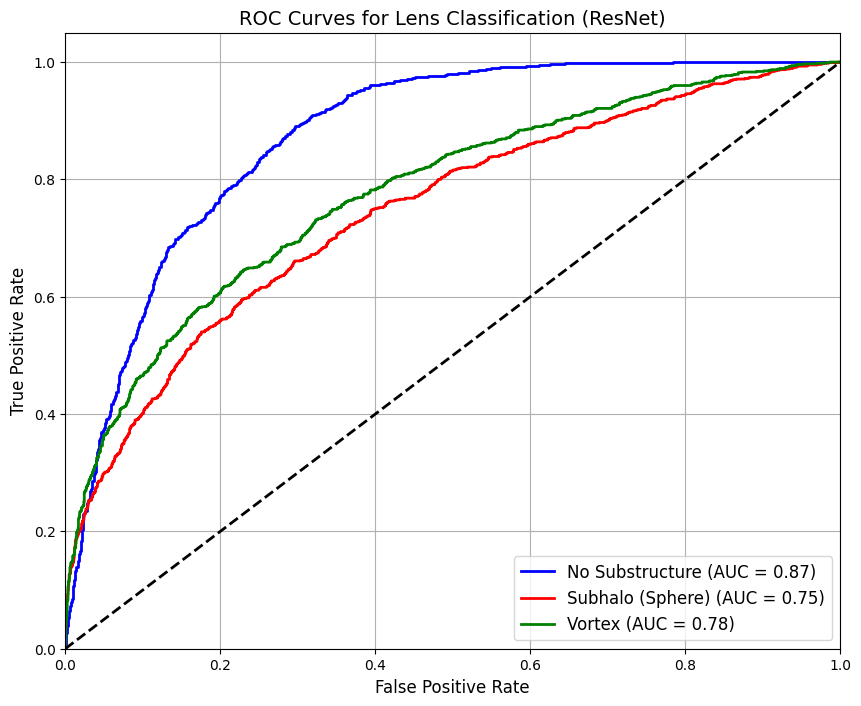

In [ ]:
# Predict probabilities for ROC curve
y_pred_prob = model.predict(X_test, batch_size=batch_size)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
class_names = ['No Substructure', 'Subhalo (Sphere)', 'Vortex']

for i, color, name in zip(range(num_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Lens Classification (ResNet)', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

# **Save final model**

In [ ]:
# Save final model
model.save('resnet50.keras')
print("Model saved as 'resnet50.keras'")

Model saved as 'resnet50.keras'
